In [20]:
import pandas as pd
import re

#### Validate the numbers by comparing the sums with those from FAO dashboard.
 - The FAO dashbord um begins from march 2020 so exclude any data before then

In [5]:
csv_data_2019_2021 = pd.read_csv("../Decrypted/DL_Treatment_data_More_precise_Location2.csv")
csv_data_2019_2021

csv_data_2019_2021_copy = csv_data_2019_2021[csv_data_2019_2021.Year > 2019]

csv_data_2019_2021_copy

,Year,Month,Country,all_Northing,all_Easting,possible_treatment_Location,T_area (ha),Lat,Lon
14,2020,Sep,SUDAN,"['1827N', '1820N', '1731N', '1337N', '1423N', ...","['3741E', '3621E', '3607E', '2522E', '2906E', ...",Dongola,9900,19.1,30.27
15,2020,Sep,ERITREA,"['1519N', '1612N', '1626N', '1515N', '1507N', ...","['3856E', '3841E', '3840E', '3937E', '4004E', ...",Mehimet,5013,17.23,38.33
16,2020,Sep,ETHIOPIA,"['1108N', '1329N', '1148N', '0935N', '0703N', ...","['3938E', '3928E', '4100E', '4150E', '3828E', ...",Obock,57457,11.57,43.17
17,2020,Sep,SOMALIA,"['0931N', '0930N', '1040N', '1017N', '0956N', ...","['4402E', '4905E', '4720E', '5014E', '4313E', ...",Mareb,17477,5.32,46.23
18,2020,Sep,KENYA,[],[],Location Missing,2100,Missing,Missing
...,...,...,...,...,...,...,...,...,...
273,2020,Dec,ETHIOPIA,"['0410N', '0504N', '0919N']","['4203E', '3723E', '4206E']",Harar,210673,9.19,42.06
274,2020,Dec,SOMALIA,"['0646N', '0444N', '0931N', '1040N', '1017N', ...","['4725E', '4512E', '4402E', '4720E', '5014E', ...",Bosaso,39101,11.18,49.1
275,2020,Dec,KENYA,"['0216S', '0402S', '0247N', '0356N']","['4054E', '3939E', '3930E', '4113E']",Rhamu,1336,3.56,41.13
276,2020,Dec,EGYPT,"['2224N', '2213N', '2308N', '2359N', '2247N', ...","['3624E', '3638E', '3535E', '3524E', '3126E', ...",Abu Simbel,235,22.19,31.38


##### get the treated area sum per country.
 -  when the data for 2019 is excluded, the sum value reduces to about 3.8 million from 6 million.
 - This is already moving closer to the FAO dashboard values.
 

In [7]:
# group the data by the country colum and compute the sum
def group_by_Country(csv_file):

    country_sum = csv_file.groupby(["Country"],as_index = False).sum()

    # Capitalize the country names to match the naming in the global data
    # drop the year information
    country_sum["Country"] = country_sum["Country"].str.title()
    country_sum = country_sum.drop(["Year"],axis=1)

    #change the country name column to match the naming on the global dataset
    country_sum = country_sum.rename(columns = {'Country': "SOVEREIGNT"})
    return country_sum

In [8]:
csv_data_2019_2021_copy_country_sum=group_by_Country(csv_data_2019_2021_copy)
csv_data_2019_2021_copy_country_sum

,SOVEREIGNT,T_area (ha)
0,Afghanistan,2969
1,Algeria,593
2,Arabia,449645
3,Djibouti,65
4,Egypt,4302
5,Eritrea,64117
6,Ethiopia,1409162
7,India,352050
8,Iran,325961
9,Iraq,2750


In [10]:
sum(csv_data_2019_2021_copy_country_sum["T_area (ha)"])

3880042

#### Make sure the entries in 2020 begins in march as the FAO data
 - At this point, we still have about 2 million more compared to the FAO dashbord. We will again filter the dataset to include only data from march 2020 and see how the sum of treated areas (ha) reduces.


In [58]:
# function to check for unique values in a list

def unique(list_):
    unique_list = []
    for item in list_:
        if item not in unique_list:
            unique_list.append(item)
    return unique_list
            

In [59]:
# check if february and Jan are included in the months column
unique(csv_data_2019_2021_copy.Month)




['Sep',
 'Oct',
 'May',
 'Aug',
 'Apr',
 'Mar',
 'Jul',
 'Nov',
 'Feb',
 'Jun',
 'Dec',
 'Jan']

In [60]:
# remove them and print the total country sum again and compare it to FAO

df2 = csv_data_2019_2021_copy[~csv_data_2019_2021_copy["Month"].isin(["Jan", "Feb"])]
#df[df['A'].isin([3, 6])]
df2
#accepted_months
unique(df2.Month)

# print the sum again.
sum(df2["T_area (ha)"])
# now the sum looks quite similar to what is showing on the FAO dashboard.

2959801

- The sum seems to move closer to 2.1 million as displayed by FAO.
-  Next thing we will do is to exclude countries in our data that are not included in tyhe FAO sum
-  these countries are: Libya, Jordan, Syria, Mali, Lebanon, Tanzania

In [70]:
countries_to_exclude = ["Libya", "Jordan", "Syria", "Mali", "Lebanon", "Tanzania"]

# We will rename the countries to have common names
def rename_country(csv_file,old_names, new_names):
    for old_name, new_name in zip(old_names,new_names):
        csv_file = csv_file.replace(old_name,new_name)
    return csv_file

df2_country_renamed = csv_data_2019_2021 = rename_country(csv_file = df2, old_names =['ARABIA'], new_names =['Saudi Arabia'])

# Capitalize each first letter of the country names
df2_country_renamed["Country"] = df2_country_renamed["Country"].str.title()
#unique(df2_country_renamed.Country)

In [71]:
df_no_countries_to_exlude = df2_country_renamed[~df2_country_renamed["Country"].isin(countries_to_exclude)]

unique(df_no_countries_to_exlude.Country)


sum(df_no_countries_to_exlude["T_area (ha)"])

#group_by_Country(df2_country_renamed)
# This further reduces the sum to 2954461 from 2959801.
# Our data is 2.95 M since March 2020 and FAO reports 2.19 M for the same period.


2954461

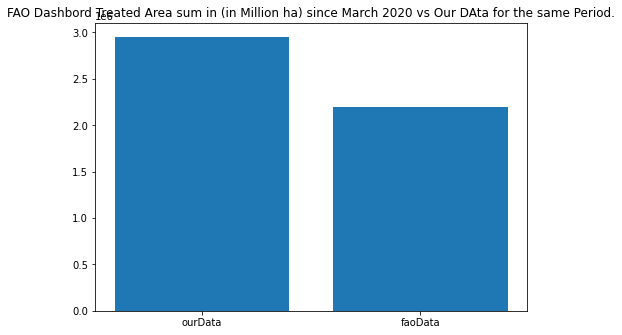

In [83]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
label = ["ourData", "faoData"]
value = [2954461,2191326]
ax.bar(label,value)
ax.set_title(f"FAO Dashbord Treated Area sum in (in Million ha) since March 2020 vs Our DAta for the same Period.")
plt.show()